In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.fft import dct, idct

import sys
sys.path.append('../notebooks/')
from helpers import title

UMAP of random contours looks a lot like 2d cosine contours!

In [2]:
def random_int_contour(N=50, n=10, p=0.5):
    contour = np.zeros((N,))
    contour[0] = np.random.randint(60,85)
    for i in range(1, N):
        step = np.random.binomial(n, p) - n*p
        step = min(max(-12, step), 12)
        if (contour[i-1] + step > 84) or (contour[i-1] + step < 60):
            contour[i] = contour[i-1] - step
        else:
            contour[i] = contour[i-1] + step
    return contour

In [3]:
import umap

In [4]:
contours = np.asarray([random_int_contour() for _ in range(10000)])
contours = contours - contours.mean(axis=1)[:, np.newaxis]

In [5]:
mapper = umap.UMAP().fit(contours)
emb = mapper.embedding_

In [10]:
def get_samples(x, y, eps=.5, num_samples=5):
    xs = np.random.uniform(x-eps, x+eps, size=num_samples)
    ys = np.random.uniform(y-eps, y+eps, size=num_samples)
    samples = np.c_[xs, ys]
    return samples

In [11]:
def mean_contours(inverse_fn, points, num_samples=5, eps=.1):
    samples = np.concatenate([get_samples(x, y, eps=eps, num_samples=num_samples) 
                              for x, y in points])
    contours = inverse_fn(samples)
    grouped = contours.reshape(len(points), num_samples, contours.shape[1])
    means = grouped.mean(axis=1)
    return means

In [12]:
grid_points = np.array([(x, y) for x in range(0, 11, 1) for y in range(0, 6, 1)])    
grid_contours = mean_contours(mapper.inverse_transform, grid_points, eps=.5, num_samples=20)

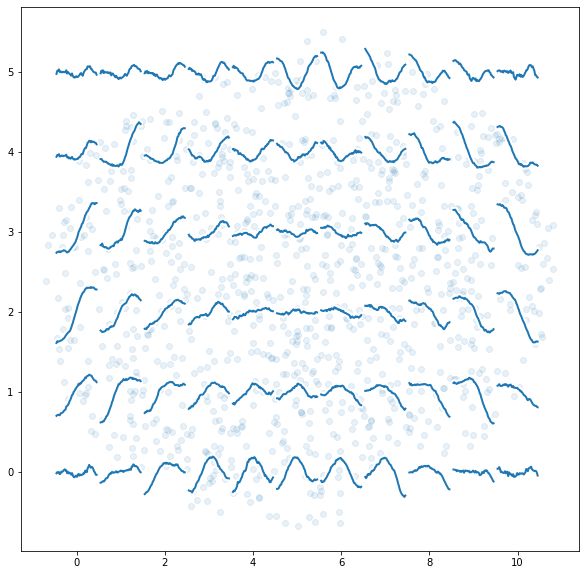

In [13]:
def inset_plot(x, y, *args, w=1, h=1, ax=None, bg=True, bg_kwargs=dict(), **kwargs):
    if ax is None: ax = plt.gca()
    axins = ax.inset_axes([x - w/2, y-h/2, w, h], transform=ax.transData)
    axins.axis('off')
    
    # Plot
    kwds = dict(lw=1.5)
    kwds.update(kwargs)
    axins.plot(*args, **kwds)
    
    # Plot background
    if bg:
        bg_kwds = dict(lw=kwds['lw']*3, color='w', zorder=1)
        bg_kwds.update(bg_kwargs)
        axins.plot(*args, **bg_kwds)

    return axins    

plt.figure(figsize=(10,10))
points = emb[:3, :]
x, y = emb[:1000, :].T
plt.scatter(x, y, alpha=.1)

for point, contour in zip(grid_points, grid_contours):
    x, y = point
    ax = inset_plot(x, y, contour, lw=2)
    ax.set_ylim(-10, 10)
